# **Boosted Stars**
# Group Members
*   Berkeley Lashley
*   Joseph Mancillas
*   Logan Hodgins
*   Kassidy Kotulan


# Loading data into Pandas

Clone dataset from my github repo at https://github.com/LoganHodgins/ML_dataset/tree/main

In [ ]:
!git clone https://github.com/LoganHodgins/ML_dataset.git

Cloning into 'ML_dataset'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


See if repo was cloned correctly, you should see ML_dataset appear.

In [ ]:
!ls

ML_dataset  sample_data


Now lets load the data into a pandas data frame that can be used for all our different models.

In [ ]:
import pandas as pd

df = pd.read_csv('ML_dataset/6 class csv.csv')

# Lets see if there is any NAN values
print('Number of NAN values: {}'.format(df.isna().sum().sum()))

# Lets see the shape of our data
print('Shape of data: {}'.format(df.shape))

# Good there is 0 NAN values, lets see what the head of the data looks like
df.head()

Number of NAN values: 0
Shape of data: (240, 7)


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,red,M
1,3042,0.000500,0.1542,16.60,0,red,M
2,2600,0.000300,0.1020,18.70,0,red,M
3,2800,0.000200,0.1600,16.65,0,red,M
4,1939,0.000138,0.1030,20.06,0,red,M


From this point on our data set is loaded and can be used for different models. However, you need to create a copy of the dataset when you use it for your model, this way you don't create conflicts with other peoples models.

Should look something like: `x = df.copy()`, this will create you own personal deep copy of the dataframe.

# SVM

Preparing the data for the SVM.

In [ ]:
from sklearn import preprocessing
# First lets copy the dataframe to be used with the SVM model
x = df.copy()

# Create a column containing our target variable
y = x['Star type'].values

# Remove Star type column from x
x.drop(columns=['Star type'], inplace=True)


# Create dummy variables
dummies = pd.get_dummies(x[['Star color', 'Spectral Class']])
x.drop(columns=['Star color', 'Spectral Class'], axis=1, inplace=True)

# Normalize x
x = (x - x.mean()) / (x.max() - x.min())

# Add dummy variables
x = pd.concat([x, dummies], axis=1)

# Create a dataset with no temperature
x_notemp = x.drop(columns=['Temperature (K)'])

# Create a dataset with no Absolute magnitude
x_nomag = x.drop(columns=['Absolute magnitude(Mv)'])

Next we are going to use best subset selection to find the best subset of predictors that contain two variables.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time
import itertools

def processSubset(feature_set, x, y):
  model = SVC(kernel='rbf', gamma='auto', decision_function_shape='ovo')
  parameters = [{'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.5, 1,2,3,4]}]
  # Use grid seach cross validation to find the best paramets for the model
  model = GridSearchCV(model, parameters, cv=10, scoring='accuracy')
  model.fit(x[list(feature_set)].values, y)
  return {'model':model.best_params_, 'score':model.best_score_, 'combo': feature_set, 'fitted_model':model.best_estimator_}

In [ ]:
# Get the best subset of 2 predictors without temperature
results = []

for combo in itertools.combinations(x_notemp.columns, 2):
  results.append(processSubset(combo, x_notemp, y))

models = pd.DataFrame(results)
best_model = models.loc[models['score'].idxmax()]

# Dataframe to hold all best models
df_model = pd.DataFrame([best_model])

In [ ]:
# Get the best subset of 2 predictors without Magnitude
results = []

for combo in itertools.combinations(x_nomag.columns, 2):
  results.append(processSubset(combo, x_nomag, y))

models = pd.DataFrame(results)
best_model = models.loc[models['score'].idxmax()]

df_model = df_model.append(best_model)

In [ ]:
# Lets find out the best parameters for the SVM built using the HR-features

best_HR = processSubset(('Temperature (K)', 'Absolute magnitude(Mv)'), x, y)

best_HR = pd.Series(best_HR)
df_model = df_model.append(best_HR, ignore_index=True)

# All best generated models
df_model.head()

,model,score,combo,fitted_model
0,"{'C': 100, 'gamma': 2}",0.991667,"(Absolute magnitude(Mv), Star color_red)","SVC(C=100, break_ties=False, cache_size=200, c..."
1,"{'C': 100, 'gamma': 3}",0.770833,"(Radius(R/Ro), Star color_orange)","SVC(C=100, break_ties=False, cache_size=200, c..."
2,"{'C': 100, 'gamma': 1}",0.987500,"(Temperature (K), Absolute magnitude(Mv))","SVC(C=100, break_ties=False, cache_size=200, c..."


Lets plot the decision boundary for both models to see how they compare to the HR-feature model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot(svc, features, y, ax, h=0.02, pad=0.25):
  X = x[list(features)].values
  x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
  y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
  z = z.reshape(xx.shape)

  ax.contourf(xx, yy, z, cmap=plt.cm.Accent, alpha=0.2)

  ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Accent)
  ax.set_xlabel(features[0])
  ax.set_ylabel(features[1])

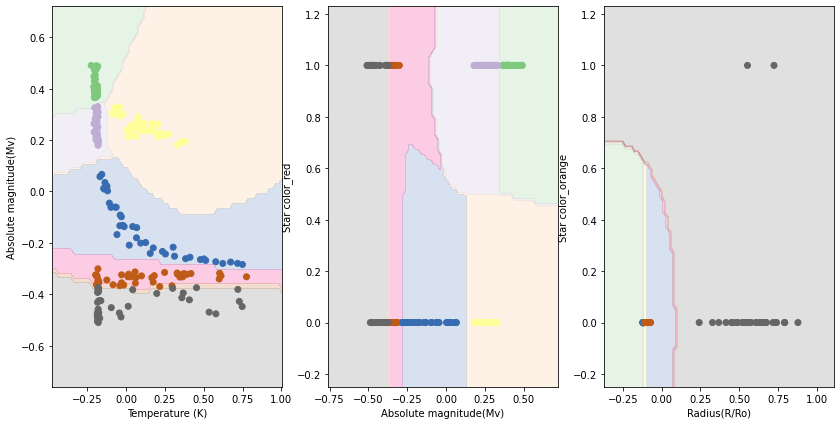

In [ ]:
from sklearn.model_selection import cross_val_predict


# HR SVC model (Temperature (K), Absolute magnitude(Mv))
HR_svc = df_model['fitted_model'].iloc[2]

# best model without temperature (Absolute magnitude(Mv), Star color_red)
notemp_svc = df_model['fitted_model'].iloc[0]

# best model without magnitude (Radius(R/Ro), Star color_orange)
nomag_svc = df_model['fitted_model'].iloc[1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(14, 7)

# plot HR model
plot(HR_svc, ['Temperature (K)', 'Absolute magnitude(Mv)'], y, ax1)

# plot the best model without temperature
plot(notemp_svc, ['Absolute magnitude(Mv)', 'Star color_red'], y, ax2)

# plot the best model without mangitude
plot(nomag_svc, ['Radius(R/Ro)', 'Star color_orange'], y, ax3)


Lets get the precision, recall, and accuracy for each trained model

In [ ]:
import seaborn as sns
def plot_matrix(cm, title, ax):
  labels = ['Brown Dwarf', 'Red Dwarf', 'White Dwarf', 
            'Main Seq', 'Supergiant', 'Hypergiant']
  sns.heatmap(cm, annot=True, ax=ax, cmap='Greys')
  ax.set_title(title)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

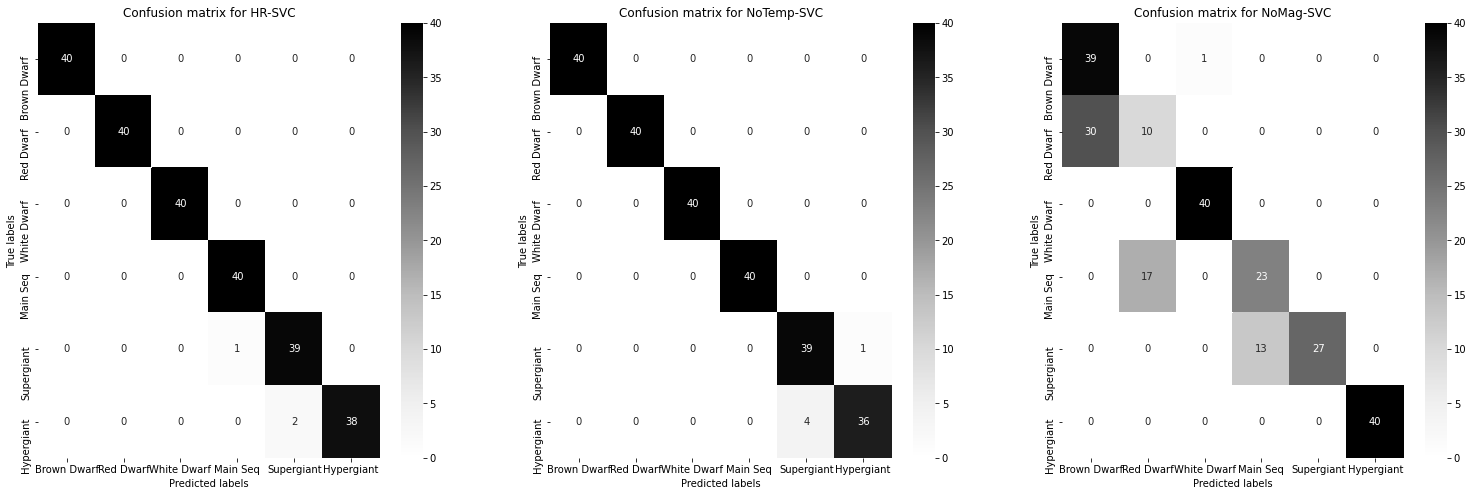

Classification report for HR-SVC
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        40
           1     1.0000    1.0000    1.0000        40
           2     1.0000    1.0000    1.0000        40
           3     0.9756    1.0000    0.9877        40
           4     0.9512    0.9750    0.9630        40
           5     1.0000    0.9500    0.9744        40

    accuracy                         0.9875       240
   macro avg     0.9878    0.9875    0.9875       240
weighted avg     0.9878    0.9875    0.9875       240

-------------------------------------------------------
Classification report for NoTemp-SVC
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        40
           1     1.0000    1.0000    1.0000        40
           2     1.0000    1.0000    1.0000        40
           3     1.0000    1.0000    1.0000        40
           4     0.9070    0.9750    0.9398        40
      

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict

HR_pred = cross_val_predict(HR_svc, x[['Temperature (K)', 'Absolute magnitude(Mv)']].values, y, cv=10)
NoTemp_pred = cross_val_predict(HR_svc, x[['Absolute magnitude(Mv)', 'Star color_red']].values, y, cv=10)
NoMag_pred = cross_val_predict(HR_svc, x[['Radius(R/Ro)', 'Star color_orange']].values, y, cv=10)

fig = plt.figure(figsize=(26, 8))

ax = plt.subplot(1, 3, 1)
plot_matrix(confusion_matrix(y, HR_pred), 'Confusion matrix for HR-SVC', ax)
fig.add_subplot(ax)

ax = plt.subplot(1, 3, 2)
plot_matrix(confusion_matrix(y, NoTemp_pred), 'Confusion matrix for NoTemp-SVC', ax)
fig.add_subplot(ax)

ax = plt.subplot(1, 3, 3)
plot_matrix(confusion_matrix(y, NoMag_pred), 'Confusion matrix for NoMag-SVC', ax)
fig.add_subplot(ax)

plt.show()

# precision, recall, and f1-score for HR-SVC
print('Classification report for HR-SVC')
print(classification_report(y, HR_pred, digits=4))
print('-------------------------------------------------------')

# precision, recall, and f1-score for NoTemp-SVC
print('Classification report for NoTemp-SVC')
print(classification_report(y, NoTemp_pred, digits=4))
print('-------------------------------------------------------')

# precision, recall, and f1-score for NoMag-SVC
print('Classification report for NoMag-SVC')
print(classification_report(y, NoMag_pred, digits=4))

# Random Forest Without HR Diagram Predictors

Preparing the data for Random Forest. First will use dataset with non HR diagram predictors.

In [ ]:
X = df.copy()
Y = X['Star type']
X = X.drop(columns=['Star type','Absolute magnitude(Mv)','Temperature (K)'])
X = pd.get_dummies(X, columns=['Spectral Class'],prefix='SpC',prefix_sep='-')
X = pd.get_dummies(X, columns=['Star color'],prefix='SC',prefix_sep='-')
X.head()

,Luminosity(L/Lo),Radius(R/Ro),SpC-A,SpC-B,SpC-F,SpC-G,SpC-K,SpC-M,SpC-O,SC-blue,SC-blue-white,SC-orange,SC-orange-red,SC-red,SC-white,SC-yellow,SC-yellow-white
0,0.002400,0.1700,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,0.000500,0.1542,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0.000300,0.1020,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,0.000200,0.1600,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,0.000138,0.1030,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


Let's create a random forest classifier using mostly default parameters

Out of Bag score:  0.9666666666666667
Confusion Matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)


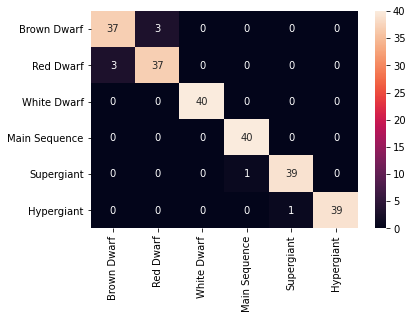

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
#the only parameter we are changin is oob_Score to true so that the out of bag score is computed
forestDefault = RandomForestClassifier(oob_score=True)

#The random forest classifer does bootstrapping so we can fit on the entire dataset and use the out of bag observations
forestDefault.fit(X,Y)
print("Out of Bag score: ",forestDefault.oob_score_)

#There is no provided predictions list by the classifier so we must create our own to find metrics
predictions= np.empty(shape=Y.shape)
observationCounter=0
for observation in forestDefault.oob_decision_function_:
  #Predict that star is class of highest probability
  #If a tie occurs the first class in the array wins
  observation = observation.tolist()
  predictions[observationCounter] = observation.index(max(observation))
  observationCounter += 1

#confusion matrx
confusionMatrix = confusion_matrix(Y,predictions)
seabornmap = sns.heatmap(confusionMatrix,annot=True,
      xticklabels=['Brown Dwarf','Red Dwarf','White Dwarf','Main Sequence','Supergiant','Hypergiant'],
      yticklabels=['Brown Dwarf','Red Dwarf','White Dwarf','Main Sequence','Supergiant','Hypergiant'])
print("Confusion Matrix:\n",seabornmap)

It looks like we are getting good OOB scores, but everytime we run the code we will get a different score due to the randomness of the bootstrapping and the randomness of predictors. So let's find and average OOB we can compare with.

In [ ]:
import statistics
from statistics import mean
#Let's do this 100 times
OOBscores = []
for i in range(101):
  forestDefault.fit(X,Y)
  OOBscores.append(forestDefault.oob_score_)
averageOOB = mean(OOBscores)

print("Average OOB Score: ", averageOOB)

Average OOB Score:  0.9677805280528052


We have a preety good average score of ~96%, so is our job done? Let's first look at our trees.

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

counter =0
for x in forestDefault.estimators_: 
  export_graphviz(forestDefault.estimators_[counter], 
                out_file = "forestDefault{counter}.dot".format(counter = counter), 
                feature_names = X.columns)
  counter+= 1

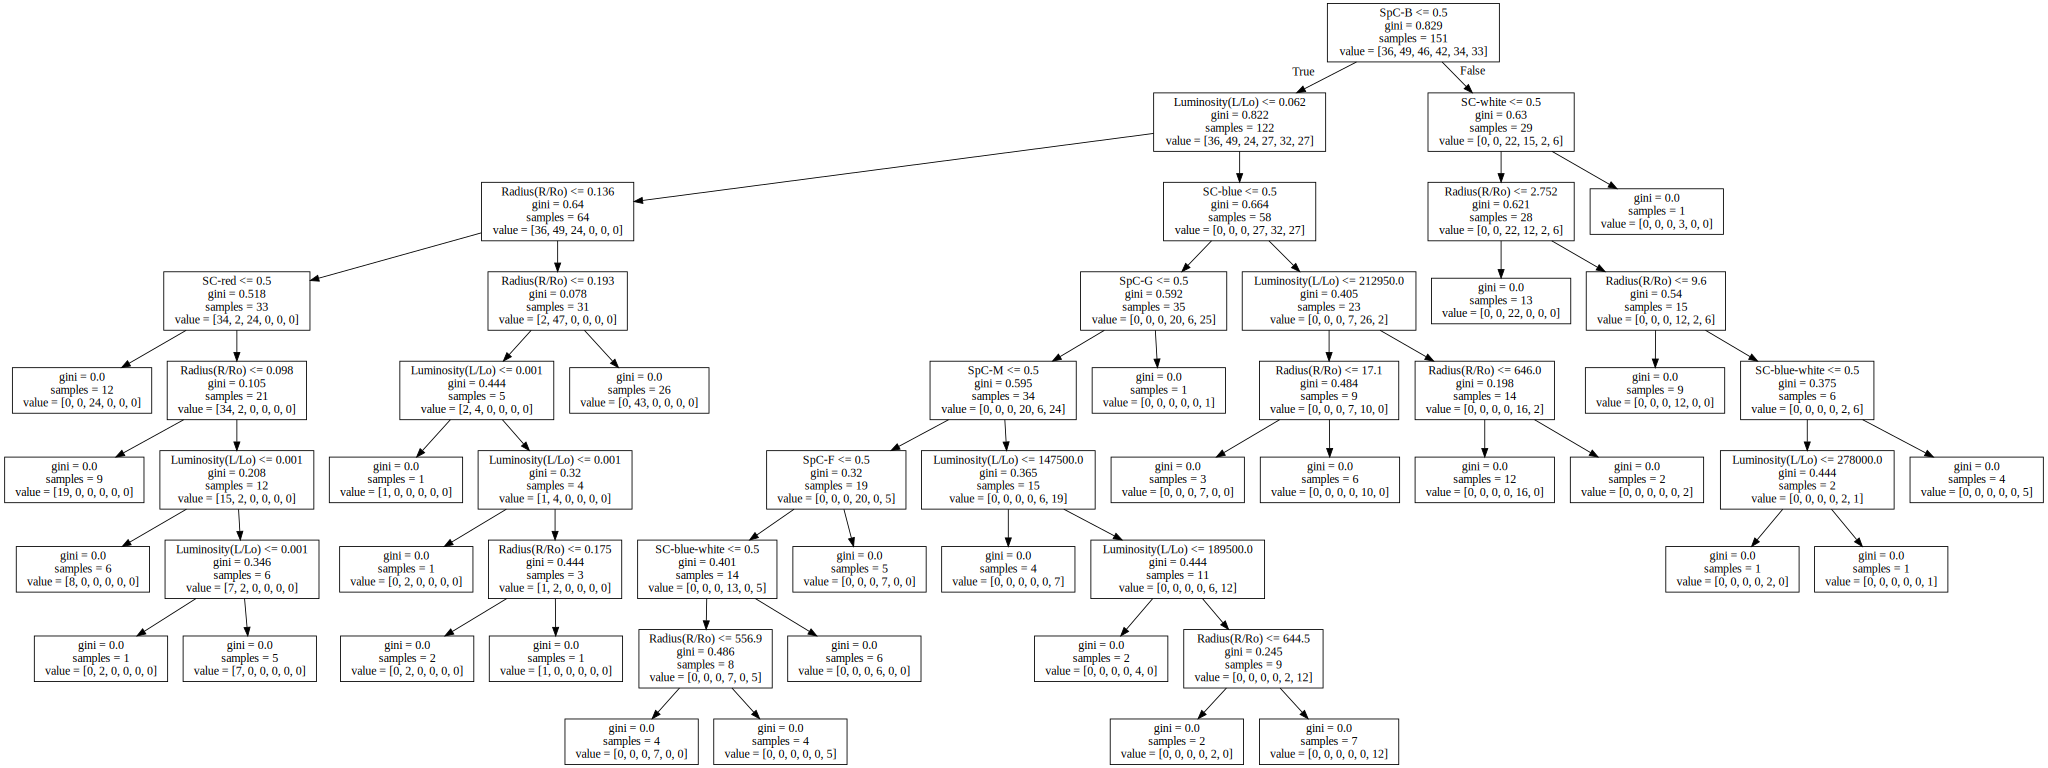

In [ ]:
#visualize a tree of the 100 tree forest (100 is the default number of trees created)
#Change the number after forestDefault, starting from 0.
with open("forestDefault0.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
#Remove those files
!rm *.dot

Our trees are very deep and on a different dataset we may have actually overfit. So let's find a value of max_depth that is small and we retain our good accuracy.

In [ ]:
maxdepthvalues = [3,4,6,7,8,9,10]
totalScoreOfDepth = [[],[],[],[],[],[],[]]
#This will take about 2 minutes and 30 seconds
for i in range(101):
  for depth in maxdepthvalues:
    forestDepth = RandomForestClassifier(max_depth=depth,oob_score=True)
    forestDepth.fit(X,Y)
    totalScoreOfDepth[maxdepthvalues.index(depth)].append(forestDepth.oob_score_)

In [ ]:
averageScoreOfDepth = [0,0,0,0,0,0,0]
for i in range(len(totalScoreOfDepth)):
  averageScoreOfDepth[i] = mean(totalScoreOfDepth[i])
  print("Average OOB score of depth {0}: {1}".format(maxdepthvalues[i],averageScoreOfDepth[i]))

Average OOB score of depth 3: 0.8937706270627063
Average OOB score of depth 4: 0.9473597359735973
Average OOB score of depth 6: 0.9684818481848185
Average OOB score of depth 7: 0.9686881188118812
Average OOB score of depth 8: 0.9681930693069307
Average OOB score of depth 9: 0.9669554455445545
Average OOB score of depth 10: 0.9683168316831683


We can see that at depth 6 we are getting a similar average OOB score as when we had a depth of 100. We can next tune the number of trees generated. With more trees we could be more accurate without the fear of overfit however it will take longer to generate more trees.

In [ ]:
numtrees = [50,60,70,100,500,1000]
totalScoreOfTrees = [[],[],[],[],[],[]]

#This will take about 6 minutes
for i in range(101):
  for num in numtrees:
    forestDepth = RandomForestClassifier(max_depth=6,oob_score=True,n_estimators=num)
    forestDepth.fit(X,Y)
    totalScoreOfTrees[numtrees.index(num)].append(forestDepth.oob_score_)

In [ ]:
averageScoreOfTrees = [0,0,0,0,0,0]
for i in range(len(totalScoreOfTrees)):
  averageScoreOfTrees[i] = mean(totalScoreOfTrees[i])
  print("Average OOB score of {0} trees: {1}".format(numtrees[i],averageScoreOfTrees[i]))

Average OOB score of 50 trees: 0.9650577557755776
Average OOB score of 60 trees: 0.9660478547854786
Average OOB score of 70 trees: 0.9668729372937294
Average OOB score of 100 trees: 0.969513201320132
Average OOB score of 500 trees: 0.9718234323432343
Average OOB score of 1000 trees: 0.9723184818481848


It looks like we can improve our score with 500 trees. Lets see if there is a value between 100 and 500 that is about as accurate as 500 trees.

In [ ]:
numtrees = [200,300,400]
totalScoreOfTrees = [[],[],[]]

#This will take about 3 minutes
for i in range(101):
  for num in numtrees:
    forestDepth = RandomForestClassifier(max_depth=6,oob_score=True,n_estimators=num)
    forestDepth.fit(X,Y)
    totalScoreOfTrees[numtrees.index(num)].append(forestDepth.oob_score_)

In [ ]:
averageScoreOfTrees = [0,0,0]
for i in range(len(totalScoreOfTrees)):
  averageScoreOfTrees[i] = mean(totalScoreOfTrees[i])
  print("Average OOB score of {0} trees: {1}".format(numtrees[i],averageScoreOfTrees[i]))

It appears that 400 trees is about as accurate as 500 trees but it's not that large of an additional time that 500 is acceptable. At the very end a model trained with a max depth of 6 and 500 trees is about 97% accurate which is similar to the average score with no tuning. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
bestModel = RandomForestClassifier(max_depth=6,n_estimators=500,oob_score=True)
bestModel.fit(X,Y)
print("Out of Bag score: ",bestModel.oob_score_)
#There is no provided predictions list by the classifier so we must create our own to find metrics
predictions= np.empty(shape=Y.shape)
observationCounter=0
for observation in bestModel.oob_decision_function_:
  #Predict that star is class of highest probability
  #If a tie occurs the first class in the array wins
  observation = observation.tolist()
  predictions[observationCounter] = observation.index(max(observation))
  observationCounter += 1

#confusion matrx
confusionMatrix = confusion_matrix(Y,predictions)
seabornmap = sns.heatmap(confusionMatrix,annot=True,
      xticklabels=['Brown Dwarf','Red Dwarf','White Dwarf','Main Sequence','Supergiant','Hypergiant'],
      yticklabels=['Brown Dwarf','Red Dwarf','White Dwarf','Main Sequence','Supergiant','Hypergiant'])
print("Confusion Matrix:\n",seabornmap)

#Most important Features
importances = bestModel.feature_importances_
std = np.std([bestModel.feature_importances_ for tree in bestModel.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

features = X.columns
importances = bestModel.feature_importances_
indices = np.argsort(importances)

plt.figure()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Random Forest HR Diagram Predictors


Now let's train a random forest on the HR diagram values.
First setup the data.

In [ ]:
X2 = df.copy()
Y2 = X2['Star type']

X2 = X2.drop(columns=['Star type','Luminosity(L/Lo)','Radius(R/Ro)','Star color','Spectral Class'])
X2.head()

,Temperature (K),Absolute magnitude(Mv)
0,3068,16.12
1,3042,16.60
2,2600,18.70
3,2800,16.65
4,1939,20.06


Let's use the default parameters

OOB:  1.0
Confusion Matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)
Decision Boundary


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


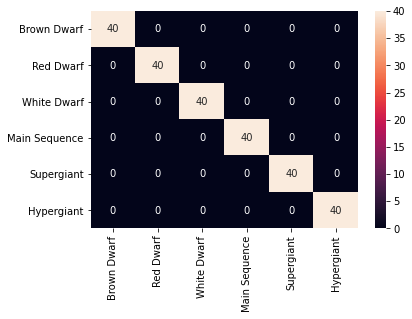

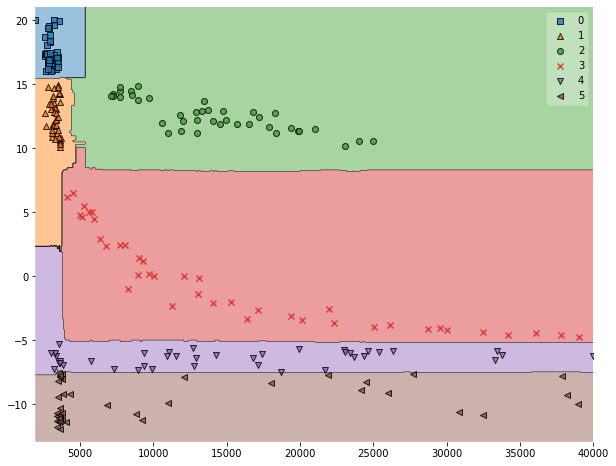

In [ ]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
forestHRDefault = RandomForestClassifier(oob_score=True)
forestHRDefault.fit(X2,Y2)
print("OOB: ",forestHRDefault.oob_score_)

#There is no provided predictions list by the classifier so we must create our own to find metrics
predictionsHR= np.empty(shape=Y2.shape)
observationCounter=0
for observation in forestHRDefault.oob_decision_function_:
  #Predict that star is class of highest probability
  #If a tie occurs the first class in the array wins
  observation = observation.tolist()
  predictionsHR[observationCounter] = observation.index(max(observation))
  observationCounter += 1

#confusion matrx
confusionMatrix = confusion_matrix(Y2,predictionsHR)
seabornmap = sns.heatmap(confusionMatrix,annot=True,
      xticklabels=['Brown Dwarf','Red Dwarf','White Dwarf','Main Sequence','Supergiant','Hypergiant'],
      yticklabels=['Brown Dwarf','Red Dwarf','White Dwarf','Main Sequence','Supergiant','Hypergiant'])
print("Confusion Matrix:\n",seabornmap)

print("Decision Boundary")
fig = plt.figure(figsize=(10,8))
fig = plot_decision_regions(X=X2.to_numpy(), y=Y2.to_numpy(), clf=forestHRDefault, legend=1)

We seem to be getting better scores closer to 100% but let's get an average

In [ ]:
#Let's do this 100 times
averageOOBHR = [];
for i in range(101):
  forestHRDefault.fit(X2,Y2)
  averageOOBHR.append(forestHRDefault.oob_score_)
averageOOBHR = mean(averageOOBHR)

print("Average OOB Score: ", averageOOBHR)

Average OOB Score:  0.9977310231023102


On average we have a 99% OOB score. But remember we have very deep trees which can lead to overfit.

In [ ]:
maxdepthvalues = [3,4,6,7,8,9,10]
totalScoreOfDepth = [[],[],[],[],[],[],[]]
#This will take about 2 minutes and 30 seconds
for i in range(101):
  for depth in maxdepthvalues:
    forestDepth = RandomForestClassifier(max_depth=depth,oob_score=True)
    forestDepth.fit(X2,Y2)
    totalScoreOfDepth[maxdepthvalues.index(depth)].append(forestDepth.oob_score_)

In [ ]:
averageScoreOfDepth = [0,0,0,0,0,0,0]
for i in range(len(totalScoreOfDepth)):
  averageScoreOfDepth[i] = mean(totalScoreOfDepth[i])
  print("Average OOB score of depth {0}: {1}".format(maxdepthvalues[i],averageScoreOfDepth[i]))

Average OOB score of depth 3: 0.9749587458745874
Average OOB score of depth 4: 0.9965759075907591
Average OOB score of depth 6: 0.9980610561056106
Average OOB score of depth 7: 0.9984323432343234
Average OOB score of depth 8: 0.9983085808580858
Average OOB score of depth 9: 0.9975660066006601
Average OOB score of depth 10: 0.9978135313531353


It looks like at a depth of 4 we are still getting 99% average OOB score. We might choose to use a depth of 3 out of concern of overfit. Like before let's tune the number of trees.

In [ ]:
numtrees = [100,200,300,400,500,1000]
totalScoreOfTrees = [[],[],[],[],[],[]]

#This will take about 6 minutes and 30s
for i in range(101):
  for num in numtrees:
    forestDepth = RandomForestClassifier(max_depth=4, oob_score=True, n_estimators=num)
    forestDepth.fit(X2,Y2)
    totalScoreOfTrees[numtrees.index(num)].append(forestDepth.oob_score_)

KeyboardInterrupt: ignored

In [ ]:
averageScoreOfTrees = [0,0,0,0,0,0]
for i in range(len(totalScoreOfTrees)):
  averageScoreOfTrees[i] = mean(totalScoreOfTrees[i])
  print("Average OOB score of {0} trees: {1}".format(numtrees[i],averageScoreOfTrees[i]))

Average OOB score of 100 trees: 0.9958745874587459
Average OOB score of 200 trees: 0.9989273927392739
Average OOB score of 300 trees: 0.9992161716171617
Average OOB score of 400 trees: 0.9995874587458746
Average OOB score of 500 trees: 0.9996287128712872
Average OOB score of 1000 trees: 0.9999587458745874


We get very small increases in OOB score for larger than 100 trees. In the end a random forest with max_depth=4 and 300 trees is about 99% accurate.

Out of Bag score:  1.0
Confusion Matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)
Decision Boundary


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


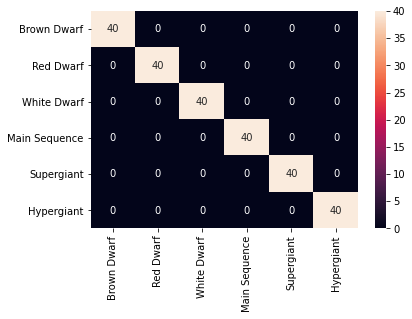

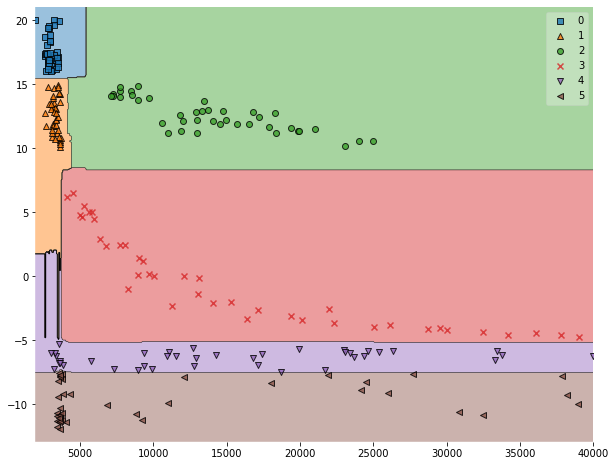

In [ ]:
bestModelHR = RandomForestClassifier(max_depth=4,n_estimators=300,oob_score=True)

bestModelHR.fit(X2,Y2)
print("Out of Bag score: ",bestModelHR.oob_score_)

#There is no provided predictions list by the classifier so we must create our own to find metrics
predictions= np.empty(shape=Y2.shape)
observationCounter=0
for observation in bestModelHR.oob_decision_function_:
  #Predict that star is class of highest probability
  #If a tie occurs the first class in the array wins
  observation = observation.tolist()
  predictions[observationCounter] = observation.index(max(observation))
  observationCounter += 1

#confusion matrx
confusionMatrix = confusion_matrix(Y,predictions)
seabornmap = sns.heatmap(confusionMatrix,annot=True,
      xticklabels=['Brown Dwarf','Red Dwarf','White Dwarf','Main Sequence','Supergiant','Hypergiant'],
      yticklabels=['Brown Dwarf','Red Dwarf','White Dwarf','Main Sequence','Supergiant','Hypergiant'])
print("Confusion Matrix:\n",seabornmap)

print("Decision Boundary")
fig = plt.figure(figsize=(10,8))
fig = plot_decision_regions(X=X2.to_numpy(), y=Y2.to_numpy(), clf=bestModelHR, legend=1)

# Boosted Trees 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
stars_df = df.copy()
stars_df.info()
print("\n")
stars_df.head()

In [ ]:
stars_df.isnull().sum()

In [ ]:
print(stars_df.shape)

Preprossing Data using label encoding

In [ ]:
from sklearn import preprocessing 

# create dummy variables
dummy_var = pd.get_dummies(stars_df[['Star color', 'Spectral Class']], dtype = int)
stars_df.drop(columns = ['Star color', 'Spectral Class'], axis = 1, inplace = True)

# Normalization of Data 
stars_df = (stars_df - stars_df.mean()) / (stars_df.max() - stars_df.min())

#Add dummy variables to data frame 
stars_df = pd.concat([stars_df, dummy_var], axis = 1)

In [ ]:
le = preprocessing.LabelEncoder()
stars_df['Temperature (K)'] = le.fit_transform(stars_df['Temperature (K)'])
stars_df['Luminosity(L/Lo)'] = le.fit_transform(stars_df['Luminosity(L/Lo)'])
stars_df['Radius(R/Ro)'] = le.fit_transform(stars_df['Radius(R/Ro)'])
stars_df['Absolute magnitude(Mv)'] = le.fit_transform(stars_df['Absolute magnitude(Mv)'])
stars_df['Star type'] = le.fit_transform(stars_df['Star type'])

In [ ]:
stars_df.head()

In [ ]:
X = stars_df.drop(['Star type'], axis = 1)
y = stars_df['Star type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(f"Stars Data HR")
print(f"X_train Shape: {X_train.shape}, y_train Shape : {y_train.shape}, X_test Shape : {X_test.shape}, y_test Shape : {y_test.shape}")

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

boosted_HR = GradientBoostingClassifier()
boosted_HR.fit(X_train,y_train)

y_hat_HR = boosted_HR.predict(X_test)

print("Model Score: ", boosted_HR.score(X_test, y_test))

fig, ax = plt.subplots(figsize=(10, 10))

titles_options = [("Confusion Matrix HR")]
for title in titles_options:
    disp = plot_confusion_matrix(boosted_HR, X_test, y_test,
                                 display_labels = ['Brown Dwarf','Red Dwarf',
                                                   'White Dwarf','Main Sequence',
                                                   'Supergiant','Hypergiant'],
                                 cmap=plt.cm.Blues,
                                 ax = ax)
    disp.ax_.set_title(title)
plt.show()

In [ ]:
X2 = stars_df.drop(['Star type', 'Absolute magnitude(Mv)','Temperature (K)'], axis = 1)
y2 = stars_df['Star type']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state = 0)

print(f"Stars Data w/o Absolute Magnitude and Temperature")
print(f"X_train Shape: {X2_train.shape}, y_train Shape : {y2_train.shape}, X_test Shape : {X2_test.shape}, y_test Shape : {y2_test.shape}")

In [ ]:
stars100 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.01,
                                           max_depth = 2)
stars100.fit(X2_train, y2_train)

In [ ]:
stars250 = GradientBoostingClassifier(n_estimators = 250, learning_rate = 0.01,
                                           max_depth = 5)
stars250.fit(X2_train, y2_train)

In [ ]:
stars500 = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.01,
                                           max_depth = 10)
stars500.fit(X2_train, y2_train)

In [ ]:
print("Model Score 100 : ", stars100.score(X2_test, y2_test))
print("Model Score 250 : ", stars250.score(X2_test, y2_test))
print("Model Score 500 : ", stars500.score(X2_test, y2_test))

Increasing the number of estimators and max depth actually hurts accuracy of the model

In [ ]:
y_hat_best = stars100.predict(X2_test)
confusion_matrix100 = confusion_matrix(y2_test, y_hat_best)

fig, ax = plt.subplots(figsize=(10, 10))

titles_options = [("Confusion Matrix 100")]
for title in titles_options:
    disp = plot_confusion_matrix(stars100, X2_test, y2_test,
                                 display_labels = ['Brown Dwarf','Red Dwarf',
                                                   'White Dwarf','Main Sequence',
                                                   'Supergiant','Hypergiant'],
                                 cmap = plt.cm.Blues,
                                 ax = ax)
    disp.ax_.set_title(title)
plt.show()


In [ ]:
feature_importance = stars100.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X2.columns).sort_values(inplace = False) 

rel_imp.T.plot(kind = 'barh', 
               color = 'b', title = 'Boosted w/o (Mv) & (K)')

plt.xlabel('Variable Importance')

plt.gca().legend_ = None


In [ ]:
feature_importance = boosted_HR.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X.columns).sort_values(inplace = False) 

rel_imp.T.plot(kind = 'barh', 
               color = 'r', title = 'HR Data')

plt.xlabel('Variable Importance')

plt.gca().legend_ = None


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report with HR \n", classification_report(y_test, y_hat_HR))
print("Classification Report w/o (Mv) & (K) \n", classification_report(y2_test, y_hat_best))

# KNN

Preparing the data for KNN

In [ ]:
from sklearn import preprocessing
x = df.copy()

# Create a column containing our target variable
y = x['Star type'].values

# Remove Star type column from x
x.drop(columns=['Star type'], inplace=True)


# Create dummy variables
dummies = pd.get_dummies(x[['Star color', 'Spectral Class']])
x.drop(columns=['Star color', 'Spectral Class'], axis=1, inplace=True)

# Normalize x
x = (x - x.mean()) / (x.max() - x.min())

# Add dummy variables
x = pd.concat([x, dummies], axis=1)

x.head()

# Data with no temp
Notemp = x.drop(columns=['Temperature (K)'])
Nomag = x.drop(columns=['Absolute magnitude(Mv)'])
Nomag.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Star color_blue,Star color_blue-white,Star color_orange,Star color_orange-red,Star color_red,Star color_white,Star color_yellow,Star color_yellow-white,Spectral Class_A,Spectral Class_B,Spectral Class_F,Spectral Class_G,Spectral Class_K,Spectral Class_M,Spectral Class_O
0,-0.195199,-0.12619,-0.121626,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,-0.195882,-0.12619,-0.121634,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,-0.207495,-0.12619,-0.121661,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,-0.202240,-0.12619,-0.121631,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,-0.224862,-0.12619,-0.121661,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


Let's find the best subset of predictors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import time
import itertools

def processSubsetKNN(feature_set, x, y):
  model = KNeighborsClassifier()
  parameters = [{'n_neighbors': [1,2,3,4,5],
                 'metric': ['euclidean', 'manhattan','chebyshev','minkowski']}]
  # Use grid seach cross validation to find the best paramets for the model
  model = GridSearchCV(model, parameters, cv=10, scoring='accuracy')
  model.fit(x[list(feature_set)].values, y)
  return {'model':model.best_params_, 'score':model.best_score_, 'combo': feature_set, 'fitted_model':model.best_estimator_}

In [ ]:
# Get the best subset of 2 predictors without temperature
results = []

for combo in itertools.combinations(Notemp.columns, 2):
  results.append(processSubsetKNN(combo, Notemp, y))

models = pd.DataFrame(results)
best_model = models.loc[models['score'].idxmax()]

# Dataframe to hold all best models
df_model = pd.DataFrame([best_model])

In [ ]:
# Get the best subset of 2 predictors without Magnitude
results = []

for combo in itertools.combinations(Nomag.columns, 2):
  results.append(processSubsetKNN(combo, Nomag, y))

models = pd.DataFrame(results)
best_model = models.loc[models['score'].idxmax()]

df_model = df_model.append(best_model)

In [ ]:
# Lets find out the best parameters for the KNN built using the HR-features

best_HR = processSubsetKNN(('Temperature (K)', 'Absolute magnitude(Mv)'), x, y)

best_HR = pd.Series(best_HR)
df_model = df_model.append(best_HR, ignore_index=True)

# All best generated models
df_model.head()

,model,score,combo,fitted_model
0,"{'metric': 'euclidean', 'n_neighbors': 1}",0.995833,"(Absolute magnitude(Mv), Star color_red)","KNeighborsClassifier(algorithm='auto', leaf_si..."
1,"{'metric': 'euclidean', 'n_neighbors': 1}",0.958333,"(Radius(R/Ro), Spectral Class_K)","KNeighborsClassifier(algorithm='auto', leaf_si..."
2,"{'metric': 'manhattan', 'n_neighbors': 1}",0.954167,"(Temperature (K), Absolute magnitude(Mv))","KNeighborsClassifier(algorithm='auto', leaf_si..."


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot(model, features, y, ax, h=0.02, pad=0.25):
  X = x[list(features)].values
  x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
  y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  z = z.reshape(xx.shape)

  ax.contourf(xx, yy, z, cmap=plt.cm.Accent, alpha=0.2)

  ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Accent)
  ax.set_xlabel(features[0])
  ax.set_ylabel(features[1])

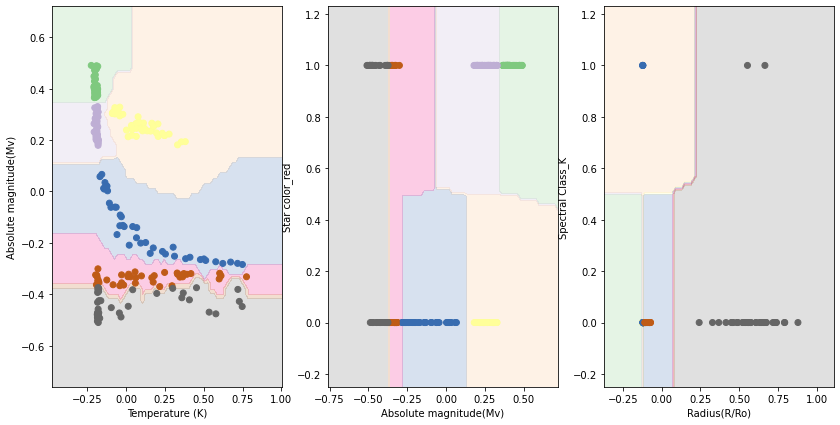

In [ ]:
from sklearn.model_selection import cross_val_predict


# HR KNN model (Temperature (K), Absolute magnitude(Mv))
HR_knn = df_model['fitted_model'].iloc[2]

# best model without temperature (Absolute magnitude(Mv), Star color_red)
notemp_knn = df_model['fitted_model'].iloc[0]

# best model without magnitude (Radius(R/Ro), Spectral Class_K)
nomag_knn = df_model['fitted_model'].iloc[1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(14, 7)

# plot HR model
plot(HR_knn, ['Temperature (K)', 'Absolute magnitude(Mv)'], y, ax1)

# plot the best model without temperature
plot(notemp_knn, ['Absolute magnitude(Mv)', 'Star color_red'], y, ax2)

# plot the best model without mangitude
plot(nomag_knn, ['Radius(R/Ro)', 'Spectral Class_K'], y, ax3)